# **Assignment 3**: Job Market Skills

In [ ]:
!pip install selenium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 1.5 MB/s 
     |████████████████████████████████| 140 kB 26.3 MB/s 
     |████████████████████████████████| 384 kB 34.5 MB/s 
     |████████████████████████████████| 58 kB 3.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.13 which is incompatible.


In [ ]:
# Import necessary libraries 
from selenium import webdriver
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
import random
import time
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
from wordcloud import WordCloud


In [ ]:
from wordcloud import STOPWORDS

## **PART I**: Web Scrapping from Indeed

Please note that i faced issues with using the driver on colab so I ran the below code on SPYDER in order to gather data and then proceeded with the analysis in section 2 of the report


In [ ]:
driver = webdriver.Chrome('./chromedirver.exe')
driver.get('https://www.indeed.com/jobs?q={}&l={}')


## Enter a job position
position = "data scientist"
## Enter a location (City, State or Zip or remote)
locations = "remote"

def get_url(position, location):
    url_template = "https://www.indeed.com/jobs?q={}&l={}"
    url = url_template.format(position, locations)
    return url

url = get_url(position, locations)
#dataframe = pd.DataFrame(columns=["Title", "Company", "Location", "Rating", "Date", "Salary", "Description", "Links"])

In [ ]:
# Next we scrap 300 jobs of remote data scientists from indeed
postings = 300

jn=0
for i in range(0, postings, 10):
    driver.get(url + "&start=" + str(i))
    driver.implicitly_wait(3)

    jobs = driver.find_elements(By.CLASS_NAME, 'job_seen_beacon')

    for job in jobs:
        result_html = job.get_attribute('innerHTML')
        soup = BeautifulSoup(result_html, 'html.parser')
        
        jn += 1
        
        liens = job.find_elements(By.TAG_NAME, "a")
        links = liens[0].get_attribute("href")
        
        title = soup.select('.jobTitle')[0].get_text().strip()
        company = soup.select('.companyName')[0].get_text().strip()
        location = soup.select('.companyLocation')[0].get_text().strip()
        try:
            salary = soup.select('.salary-snippet-container')[0].get_text().strip()
        except:
            salary = 'NaN'
        try:
            rating = soup.select('.ratingNumber')[0].get_text().strip()
        except:
            rating = 'NaN'
        try:
            date = soup.select('.date')[0].get_text().strip()
        except:
            date = 'NaN'
        try:
            description = soup.select('.job-snippet')[0].get_text().strip()
        except:
            description = ''
       
        dataframe = pd.concat([dataframe, pd.DataFrame([{'Title': title,
                                          "Company": company,
                                          'Location': location,
                                          'Rating': rating,
                                          'Date': date,
                                          "Salary": salary,
                                          "Description": description,
                                          "Links": links}])], ignore_index=True)
        print("Job number {0:4d} added - {1:s}".format(jn,title))


driver.quit()


In [ ]:
#Store links of jobs found and transform pandas dataframe to CSV file
Links_list = dataframe['Links'].tolist()
descriptions=[]
for i in Links_list:
    driver.get(i)
    driver.implicitly_wait(random.randint(3, 8))
    jd = driver.find_element(By.XPATH, '//div[@id="jobDescriptionText"]').text
    descriptions.append(jd)
    time.sleep(random.randint(5,10))

dataframe['Description'] = descriptions

driver.quit()

# Convert the dataframe to a csv file
# date = datetime.today().strftime('%Y-%m-%d')
#dataframe.to_csv('assignmnet3.csv', index=False)

# **PART II**: Feature Selection
In this section, we loop over the gathered links in order to find the following skills in remote data scientist job postings.

(["communication", "written", "presentation", "problem solving", "project management","consulting","leadership","analytic","excel","python","R","java","C/C++","MATLAB","SAS","SQL","SPSS","ML","deep learning","cloud computing","API","mathematics","tableau","Power BI","hadoop","spark","pressure","statistics","teamwork"])



In [ ]:
df=pd.read_csv(r"/content/webscraping_results_assignmnet3.csv")
df.head()

links = df['Links']
print(links.size)

#Feauture_Selection
Features_dataframe = pd.DataFrame(columns = ["communication", "written", "presentation", "problem solving", "project management","consulting","leadership","analytic","excel",
                                   "python","R","java","C/C++","MATLAB","SAS","SQL","SPSS","ML","deep learning","cloud computing","API","mathematics",
                                   "tableau","Power BI","hadoop","spark","pressure","statistics","teamwork"])

In [ ]:
# Feature Extraction 

flag=np.zeros([300,len(Features_dataframe.columns)])
# loop over all links collected, perform nlp in order to retrieve the soft 
#and hard skills chosen

driver = webdriver.Chrome("./chromedriver.exe")

for link in list(range(len(links))):
    driver.get(links[link])
    driver.implicitly_wait(5)  #to avoid being kicked out from the website
    html_source = driver.page_source
    soup2 = BeautifulSoup(html_source,'html.parser') #get HTML code for page
    txt = BeautifulSoup.get_text(soup2) #transform into text to use NLP and find skills required for first position 
    i=0;

    for skill in Features_dataframe.columns:
        if skill in txt:
            flag[link,i]=1
            
        elif skill.capitalize() in txt:
            flag[link,i]=1
            
        elif skill.title() in txt:
            flag[link,i]=1
            
        else:
            flag[link,i]=0
        i=i+1
        
    Features_dataframe = pd.concat([Features_dataframe, pd.DataFrame([{"communication" : flag[link,0], "written":flag[link,1], "presentation":flag[link,2], 
                                                                      "problem solving":flag[link,3], "project management":flag[link,4],"consulting":flag[link,5],
                                                                      "leadership":flag[link,6],"analytic":flag[link,7],"excel":flag[link,8],"python":flag[link,9],"R":flag[link,10],"java":flag[link,11],
                                                                      "C/C++":flag[link,12],"MATLAB":flag[link,13],"SAS":flag[link,14],"SQL":flag[link,15],"SPSS":flag[link,16],"ML":flag[link,17],"deep learning":flag[link,18],
                                                                      "cloud computing":flag[link,19],"API":flag[link,20],"mathematics":flag[link,21],"tableau":flag[link,22],"Power BI":flag[link,23],
                                                                      "hadoop":flag[link,24] ,"spark":flag[link,25],"pressure": flag[link,26] ,'statistics':flag[link,27],'teamwork':flag[link,28]}])], ignore_index=True)

driver.quit()
# Features_dataframe.to_csv('Checkpoint_forWebScraping.csv', index=False)  #Commented this line to avoid overwriting data, but this command was applied to get the feature datafarme

## **PART II.i**: Data Visualization

In this section we visualize the gathered data, to avoid rerunning the previous as it is time consuming, we read the Features_dataframe from the directory.


In [ ]:
Features_dataframe = pd.read_csv(r"/content/Checkpoint_forWebScraping.csv")
df=pd.read_csv(r"/content/webscraping_results_assignmnet3.csv")



In [ ]:
SoftSkills = Features_dataframe[['communication','written','presentation','problem solving',
                                 'project management','consulting','leadership','pressure','teamwork']]

Soft_Occurance = pd.DataFrame(SoftSkills.sum(), columns = ['Count'])
Soft_Occurance.head()

,Count
communication,141
written,76
presentation,40
problem solving,24
project management,15


In [ ]:
string=''
j=0
for i in Soft_Occurance.Count:
  string = string + (i*(str(Soft_Occurance.index[j])+' stop '))
  j=j+1


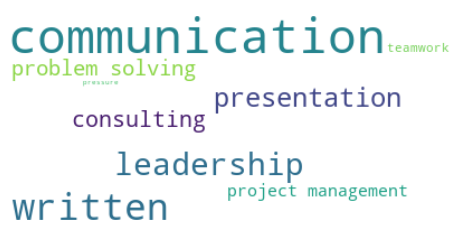

In [ ]:
stopwords = ['stop']
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(string)
plt.figure( figsize=(8,8))
plt.imshow( wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
ratio_soft = Soft_Occurance.values/300

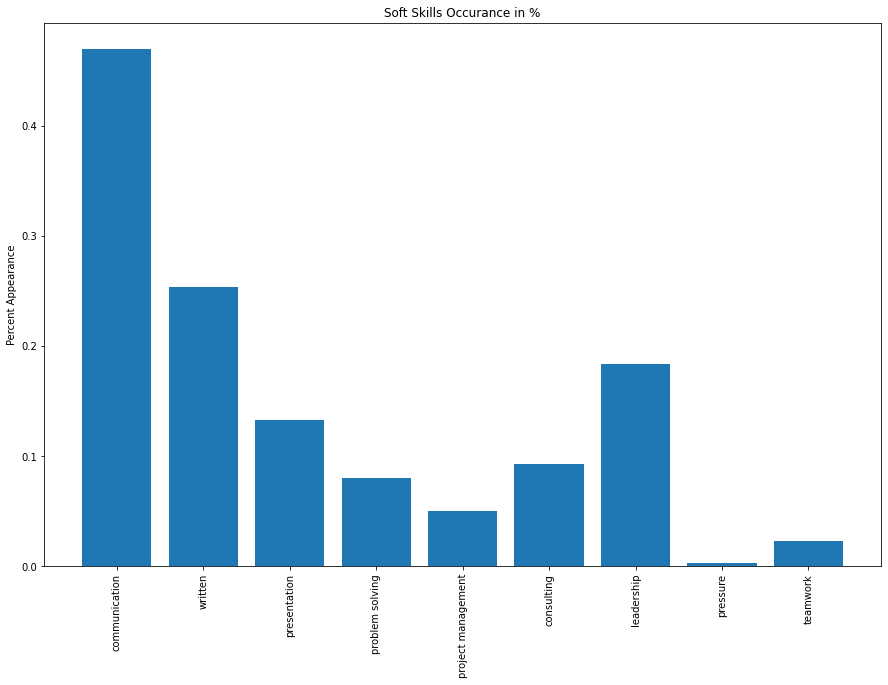

In [ ]:
r = pd.concat([pd.DataFrame(Soft_Occurance.index , columns =['skills']) , pd.DataFrame(ratio_soft , columns = ['ratio'])] , axis = 1)
fig = plt.figure()
fig.set_size_inches(15, 10)
s = r['skills']
sr = r['ratio']
plt.bar(s,sr)
plt.xticks(rotation = 90) 
plt.title('Soft Skills Occurance in %')
plt.ylabel('Percent Appearance')
plt.show()  #this shows that communication is the most wanted soft skill in the market 

In [ ]:
HardSkills = Features_dataframe[["analytic","excel","python","java","C/C++","MATLAB",
                                 "SAS","SQL","SPSS","ML","deep learning","cloud computing","API","mathematics",
                                   "tableau","Power BI","hadoop","spark","statistics"]]

Hard_Occurance = pd.DataFrame(HardSkills.sum(), columns = ['Count'])        
Hard_Occurance.head()
                         

,Count
analytic,205
excel,136
python,247
java,32
C/C++,4


In [ ]:
string=''
j=0
for i in Hard_Occurance.Count:
  string = string + (i*(str(Hard_Occurance.index[j])+' stop '))
  j=j+1

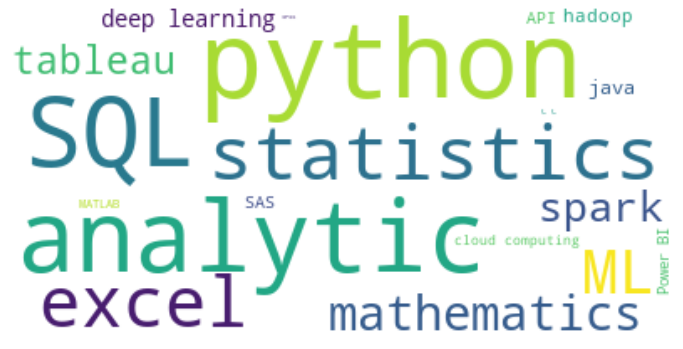

In [ ]:
stopwords = ['stop']
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(string)
plt.figure( figsize=(12,12))
plt.imshow( wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
ratio = Hard_Occurance.values/300

In [ ]:
f = pd.concat([pd.DataFrame(Hard_Occurance.index , columns =['skills']) , pd.DataFrame(ratio , columns = ['ratio'])] , axis = 1)

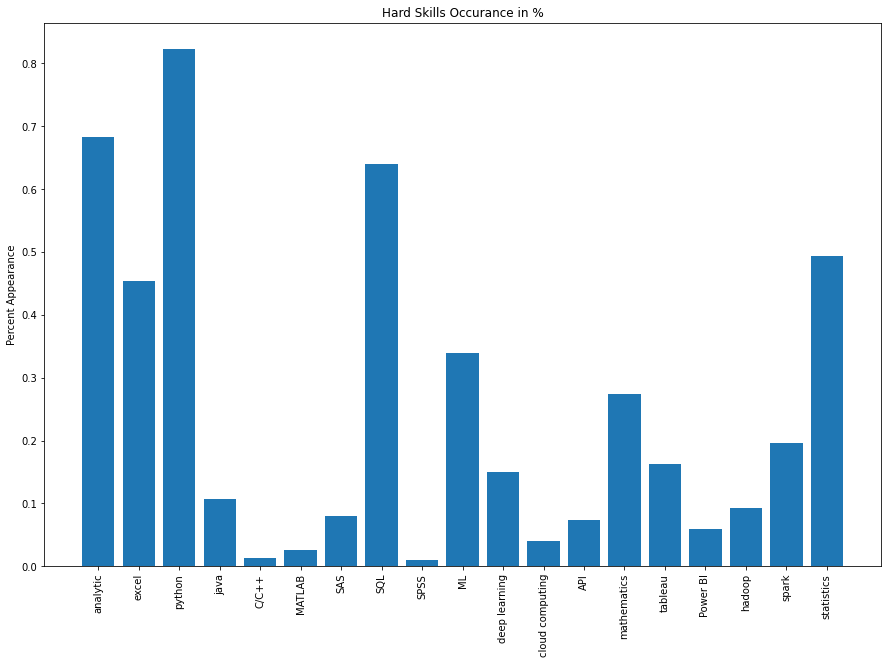

In [ ]:
fig = plt.figure()
fig.set_size_inches(15, 10)
x = f['skills']
y = f['ratio']
plt.bar(x,y)
plt.xticks(rotation = 90) 
plt.title('Hard Skills Occurance in %')
plt.ylabel('Percent Appearance')
plt.show() # this shows that python is one of the most required skills on the market at the moment. 

Text(0.5, 1.0, 'Soft Skills Segmentation')

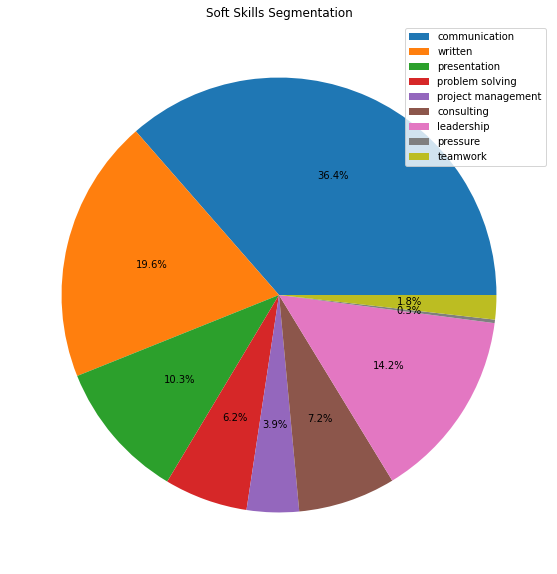

In [ ]:
# Visualizing soft skills segmentation on job market of remote data scientists
fig = plt.figure()
fig.set_size_inches(15, 10)
values = list(Soft_Occurance['Count'])
labels = list(SoftSkills.columns)
plt.pie(values , autopct='%1.1f%%', startangle = 0)
plt.legend(labels, loc = "best" )
plt.title('Soft Skills Segmentation')

Text(0.5, 1.0, 'Hard Skills Segmentation')

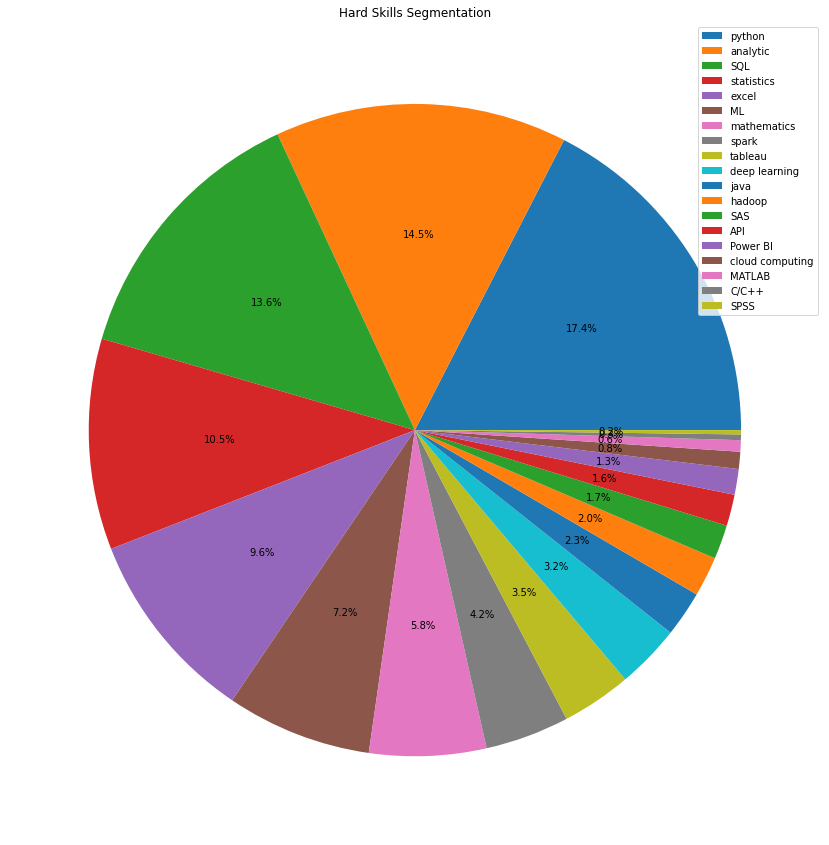

In [ ]:
# Visualizing Hard skills segmentation on job market of remote data scientists
# for hard skills we only plot the top 10 skills as they would represent the most desired skills in the market.
HardOccurance_Sorted = Hard_Occurance.sort_values(by = 'Count', ascending=False)
fig = plt.figure()
fig.set_size_inches(15, 15)
values = list(HardOccurance_Sorted['Count'])
labels = list(HardOccurance_Sorted.index)
plt.pie(values , autopct='%1.1f%%', startangle = 0)
plt.legend(labels, loc = "best" )
plt.title('Hard Skills Segmentation')

it can be seen that the most desired skill for remote datascientists is python followed by analytical skills, SQL and statistic knowledge

# **PART III**: Hierarchical Clustering 

## **PART III.i**: Set of all Skills Hierarchical Clustering 


In [ ]:
skills = pd.DataFrame(Features_dataframe.sum(), columns = ['Count'])

In [ ]:
skills = pd.DataFrame(Features_dataframe.sum(), columns = ['Count']).drop('R',axis=0)  # we dropped this column because it counted the number of time the letter R was
                                                                                        # repeated in the gathered text and not the actual skill in R programming.
X = normalize(skills.values, axis =0)
D = np.zeros([X.size,X.size])   # we normalize our data for scale consistency. 

# Find all element wise temp differences
for i in range(X.size):
    for j in range(X.size):
        D[i,j] = abs(X[i]-X[j])

<ipython-input-23-605a297713fd>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='centroid')


[]

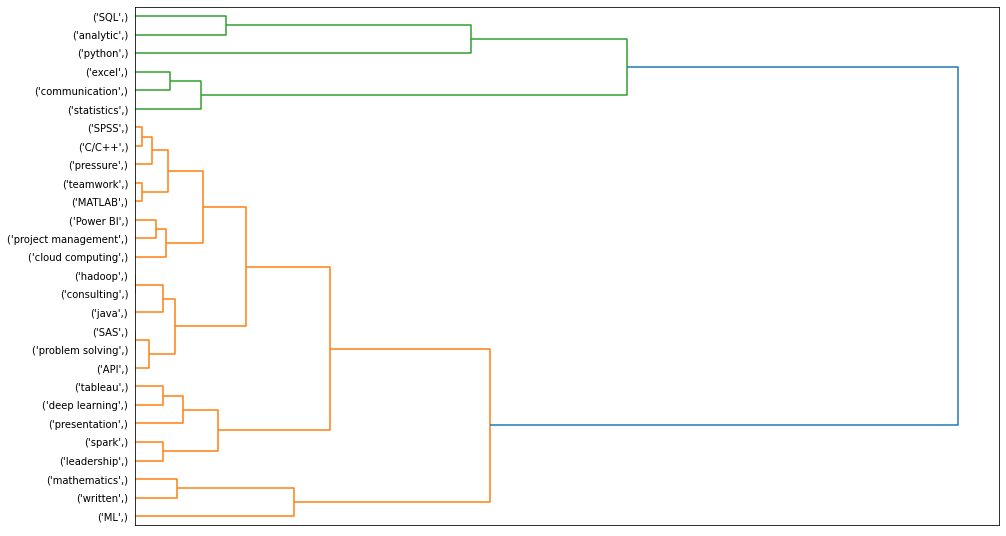

In [ ]:
Y = sch.linkage(D, method='centroid')
fig = plt.figure(figsize=(30,12))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

Z1 = sch.dendrogram(Y , orientation ='right')
labels = zip(skills.index[Z1['leaves']])
ax1.set_xticks([])
ax1.set_yticklabels(labels)
plt.plot()
# Dendrogram of all skills is shown below clustered in two major groups 

In [ ]:
skills_Cluster = sch.fcluster(Y, 0.5*D.max(),'distance')
skills['Hierarchical cluster'] = skills_Cluster-1
print(skills)  # the clusters generated by python are represented below. 

                    Count  Hierarchical cluster
communication         141                     3
written                76                     0
presentation           40                     1
problem solving        24                     2
project management     15                     2
consulting             28                     2
leadership             55                     1
analytic              205                     4
excel                 136                     3
python                247                     5
java                   32                     2
C/C++                   4                     2
MATLAB                  8                     2
SAS                    24                     2
SQL                   192                     4
SPSS                    3                     2
ML                    102                     0
deep learning          45                     1
cloud computing        12                     2
API                    22               

## **PART III.ii**: Set of Soft Skills Hierarchical Clustering 

In [ ]:
soft = normalize(Soft_Occurance.values, axis =0)
P_soft= np.zeros([soft.size,soft.size])

for i in range(soft.size):
    for j in range(soft.size):
        P_soft[i,j] = abs(soft[i]-soft[j])


<ipython-input-26-f3ae335c1934>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y_soft = sch.linkage(P_soft, method='centroid')


Text(0.5, 1.0, 'Soft Skills Dendogram')

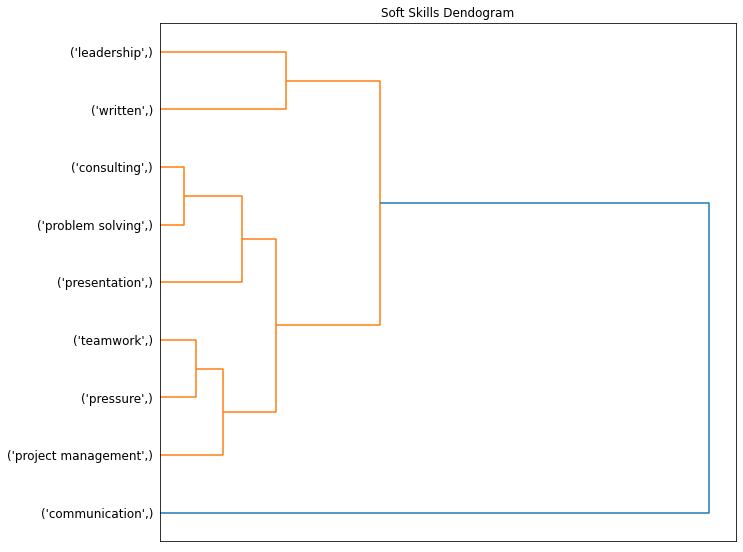

In [ ]:
Y_soft = sch.linkage(P_soft, method='centroid')
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

Z1 = sch.dendrogram(Y_soft , orientation ='right')
labels = zip(Soft_Occurance.index[Z1['leaves']])
ax1.set_xticks([])
ax1.set_yticklabels(labels)
plt.plot()
plt.title('Soft Skills Dendogram')

In [ ]:
Soft_Cluster = sch.fcluster(Y_soft, P_soft.max(),'inconsistent')
Soft_Occurance['Hierarchical cluster'] = Soft_Cluster-1
print(Soft_Occurance)

                    Count  Hierarchical cluster
communication         141                     3
written                76                     2
presentation           40                     1
problem solving        24                     1
project management     15                     0
consulting             28                     1
leadership             55                     2
pressure                1                     0
teamwork                7                     0


## **PART III.iii**: Set of Hard Skills Hierarchical Clustering 

<ipython-input-28-bf078250e2b8>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y_hard = sch.linkage(P_hard, method='centroid')


Text(0.5, 1.0, 'Hard Skills Dendogram')

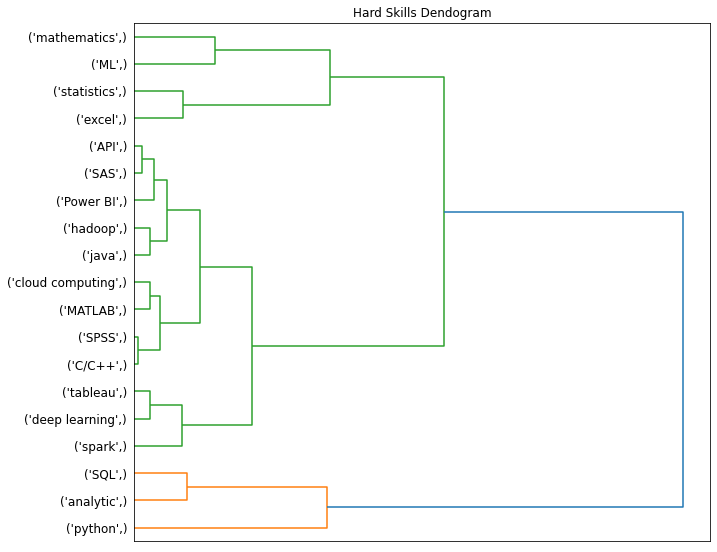

In [ ]:
Hard = normalize(Hard_Occurance.values, axis =0)
P_hard = np.zeros([Hard.size,Hard.size])

for i in range(Hard.size):
    for j in range(Hard.size):
        P_hard[i,j] = abs(Hard[i]-Hard[j])

Y_hard = sch.linkage(P_hard, method='centroid')
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

Z1 = sch.dendrogram(Y_hard , orientation ='right')
labels = zip(Hard_Occurance.index[Z1['leaves']])
ax1.set_xticks([])
ax1.set_yticklabels(labels)
plt.plot()
plt.title('Hard Skills Dendogram')


#only possible to include communication with other technical courses just like 
#MIW 1624 allowing me to develop my technical coding skills using python but also 
# develop my soft skills by encouraging business presentations and public speaking


In [ ]:
Hard_Cluster = sch.fcluster(Y_hard, P_hard.max(),'distance')
Hard_Occurance['Hierarchical cluster'] = Hard_Cluster-1
print(Hard_Occurance)

                 Count  Hierarchical cluster
analytic           205                     0
excel              136                     2
python             247                     0
java                32                     1
C/C++                4                     1
MATLAB               8                     1
SAS                 24                     1
SQL                192                     0
SPSS                 3                     1
ML                 102                     2
deep learning       45                     1
cloud computing     12                     1
API                 22                     1
mathematics         82                     2
tableau             49                     1
Power BI            18                     1
hadoop              28                     1
spark               59                     1
statistics         148                     2


# **PART IV**: KNN Clustering

In [ ]:
Soft_mapdict = {'communication':1, 'written':2, 'presentation':3, 'problem solving':4,
       'project management':5, 'consulting':6, 'leadership':7, 'pressure':8,
       'teamwork':9}

Hard_mapdict = {'analytic':10, 'excel':11, 'python':13, 'java':14, 'C/C++':15, 'MATLAB':16, 'SAS':17, 'SQL':18,
       'SPSS':19, 'ML':20, 'deep learning':21, 'cloud computing':22, 'API':23, 'mathematics':24,
       'tableau':25, 'Power BI':26, 'hadoop':27, 'spark':29, 'statistics':30}


## **PART IV.i**: KNN Clustering for Set of all Skills

Text(0.5, 1.0, 'Unscaled Skills Occurance Scatter Data')

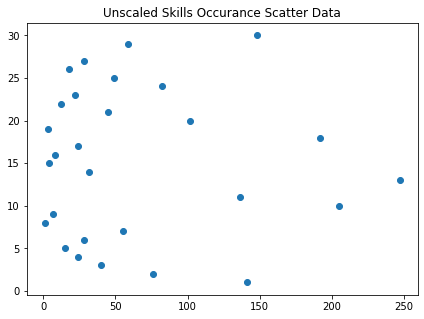

In [ ]:
#skills = skills.drop('R', axis=0)
Skills_X_Knn = skills['Count'].values
Skills_Y_Knn = (skills.index).map({**Soft_mapdict,** Hard_mapdict})

fig = plt.figure()
fig.set_size_inches(7,5)
plt.scatter(Skills_X_Knn,Skills_Y_Knn)
plt.title('Unscaled Skills Occurance Scatter Data')



Text(0.5, 1.0, 'Scaled Skills Occurance Scatter Data')

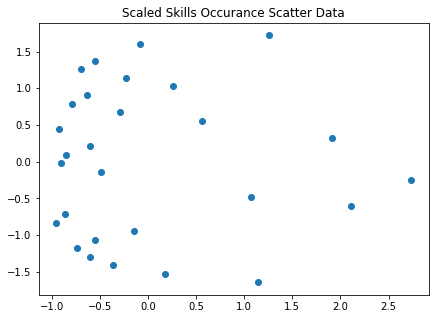

In [ ]:
loc_skills = [list(s) for s in zip(Skills_X_Knn,Skills_Y_Knn)]
scaler = StandardScaler()
loc_skills = scaler.fit_transform(loc_skills)

fig = plt.figure()
fig.set_size_inches(7,5)
plt.scatter(loc_skills[:,0],loc_skills[:,1])
plt.title('Scaled Skills Occurance Scatter Data')

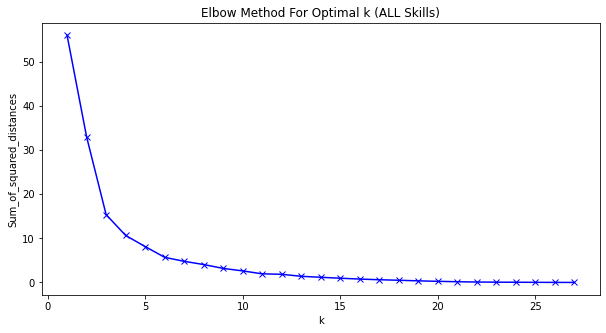

In [ ]:
L2distances = []
K = range(1,len(skills))
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(loc_skills)
    L2distances.append(km.inertia_)

fig = plt.figure()
fig.set_size_inches(10, 5)
plt.plot(K, L2distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k (ALL Skills)')
plt.show()

                    Count  Hierarchical cluster  KNN_Clusters
communication         141                     3             1
written                76                     0             2
presentation           40                     1             2
problem solving        24                     2             2
project management     15                     2             2
consulting             28                     2             2
leadership             55                     1             2
analytic              205                     4             4
excel                 136                     3             1
python                247                     5             4
java                   32                     2             0
C/C++                   4                     2             0
MATLAB                  8                     2             0
SAS                    24                     2             0
SQL                   192                     4             4
SPSS    

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'KNN Clustered Data for Scaled Skills Occurance')

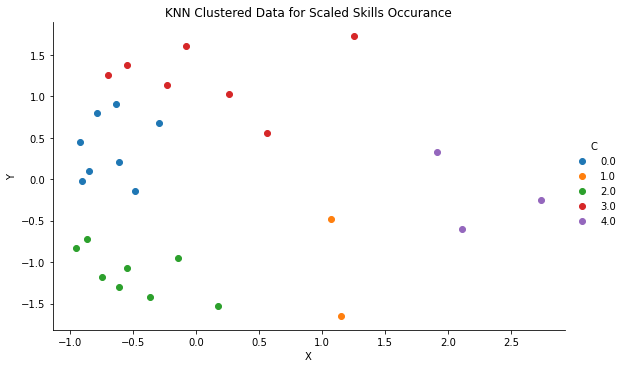

In [ ]:
# From the above elbow graph an optimal number of clusters equal to 5 should is recommended
kmeans_skills = KMeans(n_clusters=5)
# Train
kmeans_skills.fit(loc_skills)

# Get output
labels_skills = kmeans_skills.labels_ 
skills['KNN_Clusters'] = labels_skills
loc_skills_clustered = pd.DataFrame(np.append(loc_skills,labels_skills.reshape(28,1), axis=1), columns=['X','Y','C'])
print(skills)

fg = sns.FacetGrid(data=loc_skills_clustered, hue='C', aspect=1.61, size=5)
fg.map(plt.scatter, 'X', 'Y').add_legend()
plt.title('KNN Clustered Data for Scaled Skills Occurance')

## **PART IV.ii**: KNN Clustering for Set of Soft Skills


Text(0.5, 1.0, 'Unscaled Soft Skills Occurance Scatter Data')

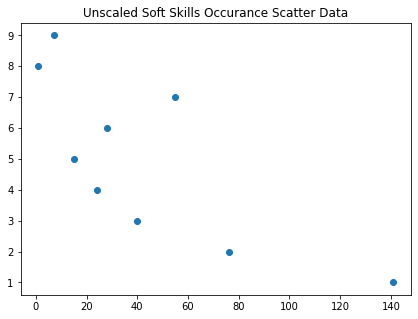

In [ ]:
Soft_X_Knn = Soft_Occurance['Count'].values
Soft_Y_Knn = (Soft_Occurance.index).map(Soft_mapdict)

fig = plt.figure()
fig.set_size_inches(7, 5)
plt.scatter(Soft_X_Knn,Soft_Y_Knn)
plt.title('Unscaled Soft Skills Occurance Scatter Data')


Text(0.5, 1.0, 'Scaled Soft Skills Occurance Scatter Data')

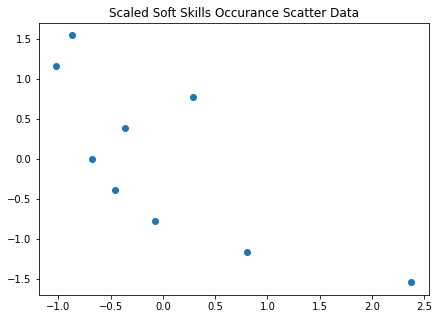

In [ ]:
loc = [list(a) for a in zip(Soft_X_Knn,Soft_Y_Knn)]
scaler = StandardScaler()
loc = scaler.fit_transform(loc)

fig = plt.figure()
fig.set_size_inches(7, 5)
plt.scatter(loc[:,0],loc[:,1])
plt.title('Scaled Soft Skills Occurance Scatter Data')

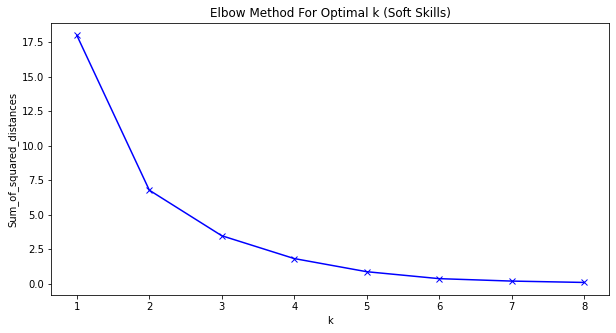

In [ ]:
L2distances = []
K = range(1,len(loc))
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(loc)
    L2distances.append(km.inertia_)

fig = plt.figure()
fig.set_size_inches(10, 5)
plt.plot(K, L2distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k (Soft Skills)')
plt.show()

                    Count  Hierarchical cluster  KNN_Clusters
communication         141                     3             3
written                76                     2             1
presentation           40                     1             1
problem solving        24                     1             0
project management     15                     0             0
consulting             28                     1             0
leadership             55                     2             0
pressure                1                     0             2
teamwork                7                     0             2


/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


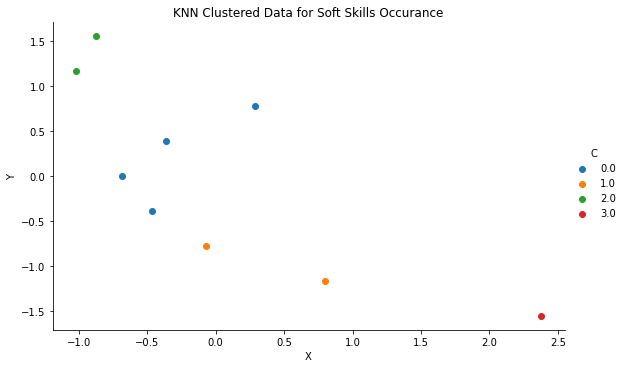

In [ ]:
# From the above graph,the optimal K to chose is 4 if we are interested in clustering of soft skills only
kmeans = KMeans(n_clusters=4)
# Train
kmeans.fit(loc)

# Get output
labels = kmeans.labels_ 
Soft_Occurance['KNN_Clusters'] = labels

loc_soft_clustered = pd.DataFrame(np.append(loc,labels.reshape(9,1), axis=1), columns=['X','Y','C'])
print(Soft_Occurance)


fg = sns.FacetGrid(data=loc_soft_clustered, hue='C', aspect=1.61, size = 5)
fg.map(plt.scatter, 'X', 'Y').add_legend()
plt.title('KNN Clustered Data for Soft Skills Occurance')
plt.show()

## **PART IV.iii**: KNN Clustering for Set of Hard Skills

Text(0.5, 1.0, 'Unscaled Hard Skills Occurance Scatter Data')

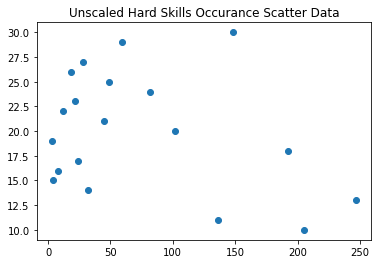

In [ ]:
Hard_X_Knn = Hard_Occurance['Count'].values
Hard_Y_Knn = (Hard_Occurance.index).map(Hard_mapdict)
plt.figure()
plt.scatter(Hard_X_Knn,Hard_Y_Knn)
plt.title('Unscaled Hard Skills Occurance Scatter Data')


Text(0.5, 1.0, 'Scaled Soft Skills Occurance Scatter Data')

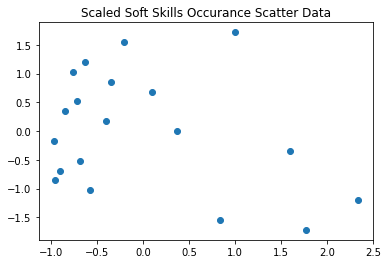

In [ ]:
loc_hard = [list(b) for b in zip(Hard_X_Knn,Hard_Y_Knn)]
scaler = StandardScaler()
loc_hard = scaler.fit_transform(loc_hard)
plt.figure()
plt.scatter(loc_hard[:,0],loc_hard[:,1])
plt.title('Scaled Soft Skills Occurance Scatter Data')

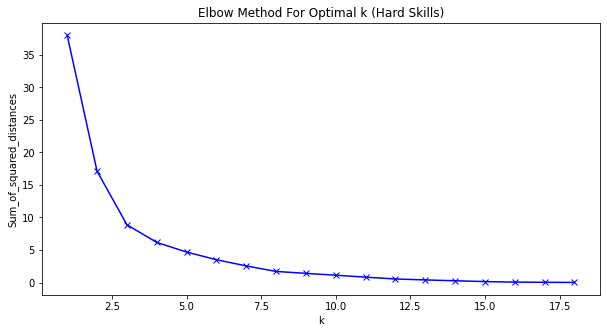

In [ ]:
L2distances = []
K = range(1,len(loc_hard-9))
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(loc_hard)
    L2distances.append(km.inertia_)

fig = plt.figure()
fig.set_size_inches(10, 5)
plt.plot(K, L2distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k (Hard Skills)')
plt.show()

                 Count  Hierarchical cluster  KNN_Clusters
analytic           205                     0             1
excel              136                     2             1
python             247                     0             1
java                32                     1             0
C/C++                4                     1             0
MATLAB               8                     1             0
SAS                 24                     1             0
SQL                192                     0             1
SPSS                 3                     1             0
ML                 102                     2             2
deep learning       45                     1             2
cloud computing     12                     1             3
API                 22                     1             3
mathematics         82                     2             2
tableau             49                     1             3
Power BI            18                     1            

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'KNN Clustered Data for Hard Skills Occurance')

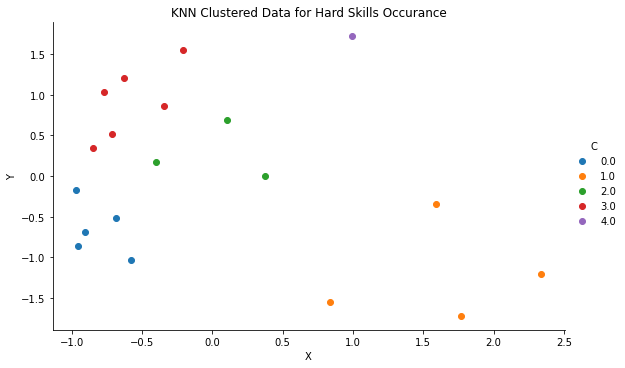

In [ ]:
kmeans_hard = KMeans(n_clusters=5)
# Train
kmeans_hard.fit(loc_hard)

# Get output
labels_hard = kmeans_hard.labels_ 
Hard_Occurance['KNN_Clusters'] = labels_hard
loc_hard_clustered = pd.DataFrame(np.append(loc_hard,labels_hard.reshape(19,1), axis=1), columns=['X','Y','C'])
print(Hard_Occurance)

fg = sns.FacetGrid(data=loc_hard_clustered, hue='C', aspect=1.61 , size =5)
fg.map(plt.scatter, 'X', 'Y').add_legend()
plt.title('KNN Clustered Data for Hard Skills Occurance')

# **PART V**: Visualization

In [ ]:
!pip install anytree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 589 kB/s 


In [ ]:
from anytree import Node, RenderTree
from anytree.exporter import DotExporter


In [ ]:
Communication = Node("Course 1 : Communication") #root
Topics = Node("Topics 1", parent=Communication)
topics1 = Node("Persuasive Communication, Workplace Communication, Networking", parent=Topics)
topics1 = Node("Effective Communication, Interaction an Influence", parent=Topics)

LeadershipnWriting= Node("Course 2: Leadership and Writing", parent=Communication)
Topics2 = Node("Topics 2", parent=LeadershipnWriting)
topics2 = Node("Relationship Building, Conflict Management, Innovation and Creativity, Project Proposals" , parent = Topics2)
topics2 = Node("Progress Reports, Technical writing, Public speaking" , parent = Topics2)

Course3 = Node("Course 3: Consulting, Problem Solving and Presentation", parent = Communication)
Topics3 = Node("Topics 3", parent=Course3)
topics3 = Node("Client Focused Thinking, Critical Thinking, Conceptual and Practical Thinking" , parent = Topics3)
topics3 = Node("Effective Communication, Value Streaming, Negotiation", parent = Topics3)

Course4 = Node("Course 4: Teamwork and Project Management", parent = LeadershipnWriting)
Topics4 = Node("Topics 4", parent = Course4)
topics4 = Node("Time Management, Scheduling, System Modeling, Risk Management, Leadership" , parent = Topics4)





for pre, fill, node in RenderTree(Communication):
    print("%s%s" % (pre, node.name))



Course 1 : Communication
├── Topics 1
│   ├── Persuasive Communication, Workplace Communication, Networking
│   └── Effective Communication, Interaction an Influence
├── Course 2: Leadership and Writing
│   ├── Topics 2
│   │   ├── Relationship Building, Conflict Management, Innovation and Creativity, Project Proposals
│   │   └── Progress Reports, Technical writing, Public speaking
│   └── Course 4: Teamwork and Project Management
│       └── Topics 4
│           └── Time Management, Scheduling, System Modeling, Risk Management, Leadership
└── Course 3: Consulting, Problem Solving and Presentation
    └── Topics 3
        ├── Client Focused Thinking, Critical Thinking, Conceptual and Practical Thinking
        └── Effective Communication, Value Streaming, Negotiation


In [ ]:
DotExporter(Communication).to_picture("Communication.png", )

In [ ]:
StatAndExcel = Node("Course 5 : Statistics and Excel") #root
Topics = Node("Topics 5", parent=StatAndExcel)
topics5 = Node("Continuous and Discrete Distributions, Bivariate Distributions, Macros programming", parent=Topics)

Course6= Node("Course 6: Mathematics and ML", parent=StatAndExcel)
Topics6 = Node("Topics 6", parent=Course6)
topics6 = Node("Linear Algebra, Convex Optimization, Probability theory" , parent = Topics6)
topics6 = Node("Statistics Multivariable calculus, Supervised Learning Models, Unsupervised Learning Models" , parent = Topics6)

Course7 = Node("Course 7:SQL", parent =StatAndExcel)
Topics7 = Node("Topics 7", parent = Course7)
topics7 = Node('Key elements of Database, Relational Keys', parent = Topics7)
topics7 = Node('Select Queries, Data Modeling, Star Schema', parent = Topics7)

Course8 = Node("Course 8: API, SAS, Power BI", parent = Course7)
Topics8 = Node("Topics 8", parent = Course8)
topics8 = Node("DAX basics, Data Preparation, ETL processes, HDFS architecture", parent = Topics8)
topics8 = Node("MapReduce architecture, JAVA environment and OOP concepts", parent = Topics8)

Course9 = Node("Course 9: Python" , parent = StatAndExcel)
Topics9 = Node("Topics 9", parent =Course9)
topics9 = Node("Modeling Techniques, Regressions, NLP", parent = Topics9)
topics9 = Node("Optimization modeling, Data Visualization, Machine Learning" , parent = Topics9)

Course10 = Node("Course 10: Deep Learning in Spark" , parent = StatAndExcel)
Topics10 = Node("Topics 10", parent = Course10)
topics10 = Node("Neural Networks, Convolutional Neural Networks, System Architecture", parent = Topics10)
topics10 = Node("Reinforcement learning, Distributed Deep learning using Spark, Intro to visualization with Tableau", parent = Topics10)

Course11 = Node("Course 11: Cloud Computing, MATLAB, C/C++" , parent = Course7)
Topics11 = Node("Topics 10" , parent = Course11)
topics11 = Node("Basics of IP Addresses, physical and virtual servers, Intro to C/C++", parent = Topics11)
topics11 = Node("ML and predictive models in MATLAB, Descriptive Statistics, and analysis," , parent = Topics11)


for pre, fill, node in RenderTree(StatAndExcel):
    print("%s%s" % (pre, node.name))



Course 5 : Statistics and Excel
├── Topics 5
│   └── Continuous and Discrete Distributions, Bivariate Distributions, Macros programming
├── Course 6: Mathematics and ML
│   └── Topics 6
│       ├── Linear Algebra, Convex Optimization, Probability theory
│       └── Statistics Multivariable calculus, Supervised Learning Models, Unsupervised Learning Models
├── Course 7:SQL
│   ├── Topics 7
│   │   ├── Key elements of Database, Relational Keys
│   │   └── Select Queries, Data Modeling, Star Schema
│   ├── Course 8: API, SAS, Power BI
│   │   └── Topics 8
│   │       ├── DAX basics, Data Preparation, ETL processes, HDFS architecture
│   │       └── MapReduce architecture, JAVA environment and OOP concepts
│   └── Course 11: Cloud Computing, MATLAB, C/C++
│       └── Topics 10
│           ├── Basics of IP Addresses, physical and virtual servers, Intro to C/C++
│           └── ML and predictive models in MATLAB, Descriptive Statistics, and analysis,
├── Course 9: Python
│   └── Topics 9
│  

In [ ]:
DotExporter(StatAndExcel).to_picture("StatAndExcelt.png", )

In [ ]:
FinalDataFrame = pd.concat([df , Features_dataframe], axis =1)


In [ ]:
FinalDataFrame.to_csv('Webscraping_results_assignmnet3.csv', index=False)